In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import numpyro
import numpyro.distributions as dist 
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer import MCMC, NUTS
from jax import random
import jax.numpy as jnp
import jax
numpyro.set_host_device_count(8)

In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


cpu


In [3]:
zeisel = pd.read_csv("Zeisel_UMI_counts.txt", sep = "\t")
zeisel = zeisel.set_index("GeneID").T
cnt_mat = zeisel.to_numpy()

In [4]:
gene = "Zbed3"

n_g = zeisel[gene].values
N_c = cnt_mat.sum(axis = 1)

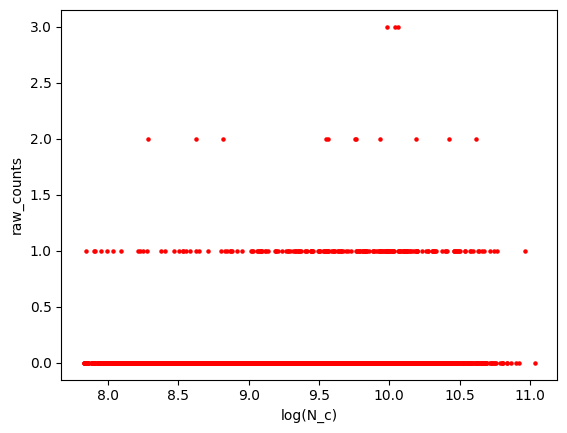

In [5]:
plt.scatter(np.log(N_c), n_g, c = "r", s = 5)
plt.ylabel("raw_counts")
plt.xlabel("log(N_c)");

In [8]:

def sanity_model(n_g, N_c):
    """
    n_g - is the vector of counts of gene g across all cells is the observed data
    N_c - is the total count of gene transcripts in a given cell.
    
    """

    α_g = numpyro.sample("α_g", dist.Uniform(0, 1))
    v_gi = numpyro.sample("v_gi", dist.Uniform(jnp.log(0.001), jnp.log(50)))
    v_g = jnp.exp(v_gi)
    cell_plate = numpyro.plate("cell_plate", size = n_g.shape[0])
    
    with cell_plate:
        δ_gc = numpyro.sample("δ_gc", dist.Normal(loc = 0., scale = v_g))
        fold_change = numpyro.deterministic("fold_change", jnp.exp(δ_gc))
        
        α_gc = numpyro.deterministic("α_gc", α_g*fold_change)
        rate = numpyro.deterministic ("rate", N_c*α_gc)
        numpyro.sample("n_cg", dist.Poisson(rate = rate), obs=n_g)

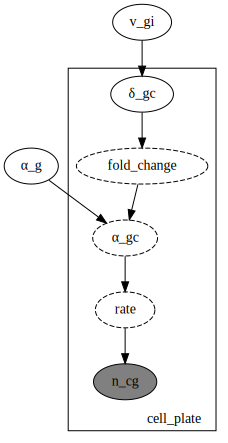

In [9]:
numpyro.render_model(sanity_model, model_args=(n_g,N_c,))

In [12]:
zsan = pd.read_csv("Zeisel_Sanity_normalization.txt", sep = "\t")
zsan = zsan.set_index("GeneID").T
cnt_mat_san = zsan.to_numpy()

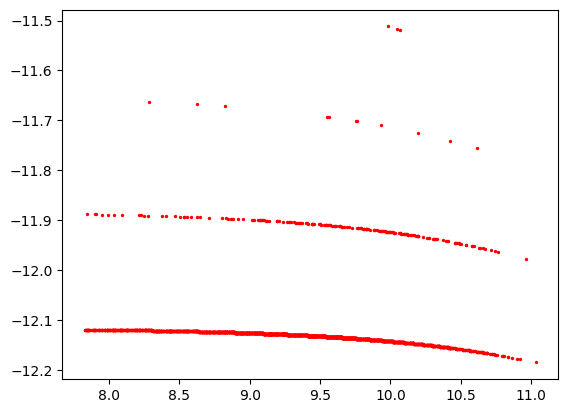

In [13]:
plt.scatter(np.log(N_c), zsan[gene] , c = "r", s = 2)

In [14]:
cnt_mat_san.shape, cnt_mat.shape

((3005, 19972), (3005, 19972))

In [15]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(sanity_model)
num_samples = 4000
num_chains = 8
mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples, num_chains = num_chains,progress_bar = False)


In [16]:
%%time
mcmc.run(
    rng_key_, n_g, N_c
)

CPU times: user 2min 19s, sys: 5.43 s, total: 2min 25s
Wall time: 33.5 s


In [17]:
estimates = mcmc.get_samples()

In [19]:
alpha_g = estimates["α_g"].mean()
delta_gcs = estimates["δ_gc"].mean(axis = 0)

In [20]:
vals = np.log(alpha_g*np.exp(delta_gcs))

In [21]:
R_mine = np.corrcoef(np.log(N_c), vals)[0, 1]
R_paper = -0.035

Text(8, -11.3, 'R_sanity : -0.035')

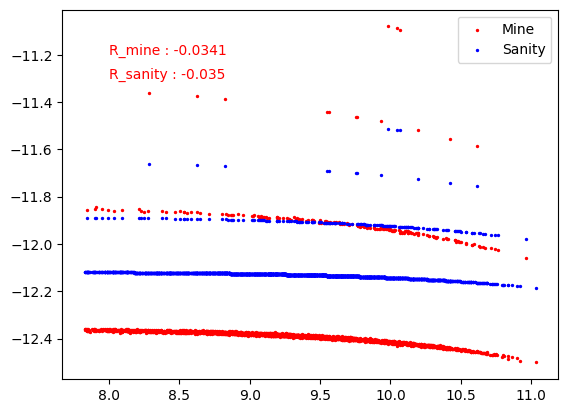

In [22]:
plt.scatter(np.log(N_c), vals, c= "r", s = 2, label = "Mine")
plt.scatter(np.log(N_c), zsan[gene], c= "b", s = 2, label = "Sanity")
plt.legend()
plt.text(8, -11.2, f"R_mine : {round(R_mine, 4)}", {"color":"r"})
plt.text(8, -11.3, f"R_sanity : {R_paper}", {"color": "r"})

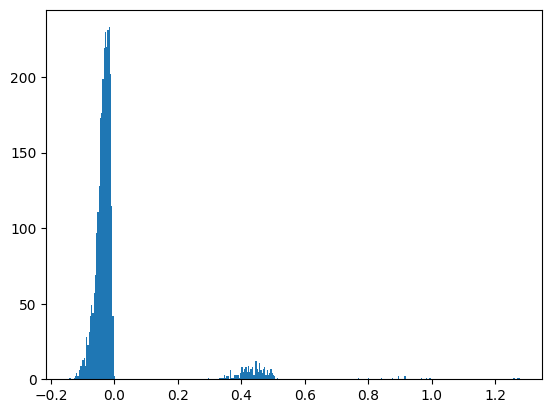

In [30]:
plt.hist(delta_gcs, bins="auto");